## frameworks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import math
from torch.profiler import profile, record_function, ProfilerActivity
import gc

torch.set_float32_matmul_precision('high')

# Function level Code but with F.linear
class OriginalDropoutFunction(Function):
    @staticmethod
    def forward(ctx, input, weight, keep_ratio=0.5):
        # --- Full Forward Pass ---
        output = F.linear(input, weight)
        # --- Memory-Saving "Backdrop" ---
        # Now, create the reduced tensors that you will need for the backward pass.
        num_cols_to_keep = int(weight.size(1) * keep_ratio)
        kept_cols_indices = torch.randperm(weight.size(1), device=input.device)[:num_cols_to_keep]
        input_reduced = input[:, kept_cols_indices]
        # Save only the reduced input and other necessary components.
        # We also need the original weight to recompute the reduced weight in backward.
        ctx.save_for_backward(input_reduced, weight)
        ctx.kept_cols_indices = kept_cols_indices
        ctx.input_shape = input.shape # Needed for reconstructing grad_input
        return output
    @staticmethod
    def backward(ctx, grad_output):
        if not ctx.needs_input_grad[0] and not ctx.needs_input_grad[1]:
            return None, None, None
        input_reduced, weight = ctx.saved_tensors
        kept_cols_indices = ctx.kept_cols_indices
        grad_input = grad_weight = None
        # --- Recomputation Step ---
        # Re-create the reduced weight tensor on-the-fly.
        weight_reduced = weight[:, kept_cols_indices]
        # --- Gradient Calculation ---
        # Now, compute gradients using the reduced tensors.
        if ctx.needs_input_grad[1]: # Gradient for weight
            grad_weight_reduced = grad_output.t().mm(input_reduced)
            grad_weight = torch.zeros_like(weight)
            grad_weight[:, kept_cols_indices] = grad_weight_reduced
        if ctx.needs_input_grad[0]: # Gradient for input
            grad_input_reduced = grad_output.mm(weight_reduced)
            grad_input = torch.zeros(ctx.input_shape, device=grad_output.device)
            grad_input[:, kept_cols_indices] = grad_input_reduced
        return grad_input, grad_weight, None

# Function level Code but with F.linear surrounded by torch.no_grad()
class FixedDropoutFunction(Function):
    @staticmethod
    def forward(ctx, input, weight, keep_ratio=0.5):
        # --- Full Forward Pass ---
        with torch.no_grad():
            output = F.linear(input, weight)
        # --- Memory-Saving "Backdrop" ---
        # Now, create the reduced tensors that you will need for the backward pass.
        num_cols_to_keep = int(weight.size(1) * keep_ratio)
        kept_cols_indices = torch.randperm(weight.size(1), device=input.device)[:num_cols_to_keep]
        input_reduced = input[:, kept_cols_indices]
        # Save only the reduced input and other necessary components.
        # We also need the original weight to recompute the reduced weight in backward.
        ctx.save_for_backward(input_reduced, weight)
        ctx.kept_cols_indices = kept_cols_indices
        ctx.input_shape = input.shape # Needed for reconstructing grad_input
        return output

    @staticmethod
    def backward(ctx, grad_output):
        if not ctx.needs_input_grad[0] and not ctx.needs_input_grad[1]:
            return None, None, None
        input_reduced, weight = ctx.saved_tensors
        kept_cols_indices = ctx.kept_cols_indices
        grad_input = grad_weight = None
        # --- Recomputation Step ---
        # Re-create the reduced weight tensor on-the-fly.
        weight_reduced = weight[:, kept_cols_indices]
        # --- Gradient Calculation ---
        # Now, compute gradients using the reduced tensors.
        if ctx.needs_input_grad[1]: # Gradient for weight
            grad_weight_reduced = grad_output.t().mm(input_reduced)
            grad_weight = torch.zeros_like(weight)
            grad_weight[:, kept_cols_indices] = grad_weight_reduced
        if ctx.needs_input_grad[0]: # Gradient for input
            grad_input_reduced = grad_output.mm(weight_reduced)
            grad_input = torch.zeros(ctx.input_shape, device=grad_output.device)
            grad_input[:, kept_cols_indices] = grad_input_reduced
        return grad_input, grad_weight, None

# nn.Module level Code in sbp-style code
class BackdropLinear(nn.Module):
    def __init__(self, in_features, out_features, keep_ratio=0.5, bias=True):
        super(BackdropLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.keep_ratio = keep_ratio

        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.randn(out_features))

        self.reset_parameters()

    def reset_parameters(self):
        fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(self.weight)
        effective_fan_in = fan_in * self.keep_ratio

        gain = nn.init.calculate_gain('leaky_relu', math.sqrt(5))
        std = gain / math.sqrt(effective_fan_in)
        bound = math.sqrt(3.0) * std

        with torch.no_grad():
            self.weight.uniform_(-bound, bound)

        if self.bias is not None:
            bound = 1 / math.sqrt(effective_fan_in)
            nn.init.uniform_(self.bias, -bound, bound)


    def forward(self, input):
        kept_cols = torch.rand(self.in_features, device=input.device) < self.keep_ratio
        kept_cols = kept_cols.bool()
        # drop_cols = ~kept_cols

        # input_kept = input[:, kept_cols]
        # input_drop = input[:, drop_cols]

        output = F.linear(input[:, kept_cols], self.weight[:, kept_cols], self.bias)
        with torch.no_grad():
            output += F.linear(input[:, ~kept_cols], self.weight[:, ~kept_cols], self.bias)

        return output

/local/scratch/a/gong123/anaconda3/envs/internet-learning/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
class ColumnwiseStructuredBackDropLinear(nn.Module):
    def __init__(self, in_features, out_features, keep_ratio, backdrop_method='fixed', bias=True, init_adjusted=False):

        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.keep_ratio = keep_ratio

        if init_adjusted:
            self.reset_parameters_adjusted()
        else:
            self.reset_parameters()

        if backdrop_method == 'fixed':
            self.backdrop_function = FixedDropoutFunction
        elif backdrop_method == 'original':
            self.backdrop_function = OriginalDropoutFunction
        else:
            raise ValueError("Invalid backdrop_method. Choose 'fixed' or 'original'.")

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight)
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / (fan_in ** 0.5)
            nn.init.uniform_(self.bias, -bound, bound)

    def reset_parameters_adjusted(self):
        # Adjusted Kaiming initialization for partial updates
        fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(self.weight)

        # Calculate effective fan_in based on keep_ratio
        effective_fan_in = fan_in * self.keep_ratio

        # Kaiming uniform with adjusted fan_in
        gain = nn.init.calculate_gain('leaky_relu', math.sqrt(5))
        std = gain / math.sqrt(effective_fan_in)
        bound = math.sqrt(3.0) * std

        with torch.no_grad():
            self.weight.uniform_(-bound, bound)

        # Adjusted bias initialization
        if self.bias is not None:
            bound = 1 / math.sqrt(effective_fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input, training=True):
        return self.backdrop_function.apply(input, self.weight, self.keep_ratio)

## Simple Model

In [3]:
class SimpleTestModel(nn.Module):
    # The 'use_backdrop' argument is now correctly included in the constructor
    def __init__(self, input_dim, hidden_dim, output_dim, keep_ratio=0.5, backdrop_method="No_drop", device='cpu'):
        super().__init__()
        self.keep_ratio = keep_ratio
        self.backdrop_method = backdrop_method

        if self.backdrop_method == "No_drop":
            self.layer1 = nn.Linear(input_dim, hidden_dim).to(device)
            self.layer2 = nn.Linear(hidden_dim, output_dim).to(device)
        elif self.backdrop_method == "fixed":
            self.layer1 = ColumnwiseStructuredBackDropLinear(input_dim, hidden_dim, keep_ratio=keep_ratio, backdrop_method='fixed', init_adjusted=True).to(device)
            self.layer2 = ColumnwiseStructuredBackDropLinear(hidden_dim, output_dim, keep_ratio=keep_ratio, backdrop_method='fixed', init_adjusted=True).to(device)
        elif self.backdrop_method == "original":
            self.layer1 = ColumnwiseStructuredBackDropLinear(input_dim, hidden_dim, keep_ratio=keep_ratio, backdrop_method='original', init_adjusted=True).to(device)
            self.layer2 = ColumnwiseStructuredBackDropLinear(hidden_dim, output_dim, keep_ratio=keep_ratio, backdrop_method='original', init_adjusted=True).to(device)
        elif self.backdrop_method == "sbp-style":
            self.layer1 = BackdropLinear(input_dim, hidden_dim, keep_ratio=keep_ratio).to(device)
            self.layer2 = BackdropLinear(hidden_dim, output_dim, keep_ratio=keep_ratio).to(device)
        else:
            raise ValueError("Invalid backdrop_method. Choose 'No_drop', 'Function_fixed', 'Function_original', or 'sbp-style'.")

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)

        return x

## Profiling

In [4]:
def profile_model(model, inputs, label, device):
    # Ensure all tensors for the training step are on the correct device
    model.to(device)
    inputs = inputs.to(device)

    # Use a simple loss function and optimizer for a realistic training step
    model.train()
    gc.collect()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()
    targets = torch.randint(0, 10, (inputs.shape[0],), device=device)

    schedule = torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1)

    # --- UPDATED TRACE HANDLER ---
    # Define the trace handler to save both the Chrome trace and the memory timeline
    def trace_handler(p):
        # Export the standard Chrome trace for operator/kernel timelines
        chrome_trace_filename = f"./{label}_trace.json"
        # p.export_chrome_trace(chrome_trace_filename)
        # Export the memory timeline to a separate HTML file [11]
        memory_timeline_filename = f"./{label}_memory_timeline.html"
        p.export_memory_timeline(memory_timeline_filename, device=device)
        # p.export_memory_timeline(f"./{label}_memory_timeline.json.gz")
        print(f"\nMemory timeline for '{label}' saved to {memory_timeline_filename}")
        # except ValueError as e:
        #     print(f"Error exporting memory timeline: {e}")
        p.export_chrome_trace(f"./{label}_trace.json")
        print(f"\nTrace for '{label}' saved to {chrome_trace_filename}")

    # Configure and run the profiler
    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        profile_memory=True,
        record_shapes=True,
        with_stack=True,
        on_trace_ready=trace_handler
    ) as prof:
        for _ in range(3): # Run a couple of steps for warmup and profiling
            with record_function("forward_pass"):
                outputs = model(inputs)

            with record_function("loss_computation"):
                loss = loss_fn(outputs, targets)

            with record_function("backward_pass"):
                loss.backward()

            with record_function("optimizer_step"):
                optimizer.step()
                optimizer.zero_grad()

            prof.step() # Signal the profiler to record the step

## Running the profiling without compiling

In [5]:
# # --- Main Execution ---
# if __name__ == "__main__":
#     # Model parameters
#     batch_size = int(102400)
#     input_dim = 1024
#     hidden_dim = 4096
#     output_dim = 1024
#     keep_ratio = 0.1
#     device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
#     print(f"Using device: {device}")
#
#     # --- Profile the standard model ---
#     print("Profiling standard nn.Linear model...")
#     standard_model = SimpleTestModel(input_dim, hidden_dim, output_dim, backdrop_method="No_drop", device=device)
#     inputs = torch.randn(batch_size, input_dim)
#     profile_model(standard_model, inputs, "standard_model", device)
#
#     # --- Profile the backdrop model ---
#     for methods in ["fixed", "original", "sbp-style"]:
#         print(f"Profiling {methods} model...")
#         backdrop_model = SimpleTestModel(input_dim, hidden_dim, output_dim, backdrop_method=methods, keep_ratio=keep_ratio, device=device)
#         inputs = torch.randn(batch_size, input_dim)
#         profile_model(backdrop_model, inputs, f"{methods}_model", device)


## Running the profiling with compiling

Using device: cuda:1
Profiling fixed model...

Memory timeline for 'sbp-style_model' saved to ./sbp-style_model_memory_timeline.html

Trace for 'sbp-style_model' saved to ./sbp-style_model_trace.json


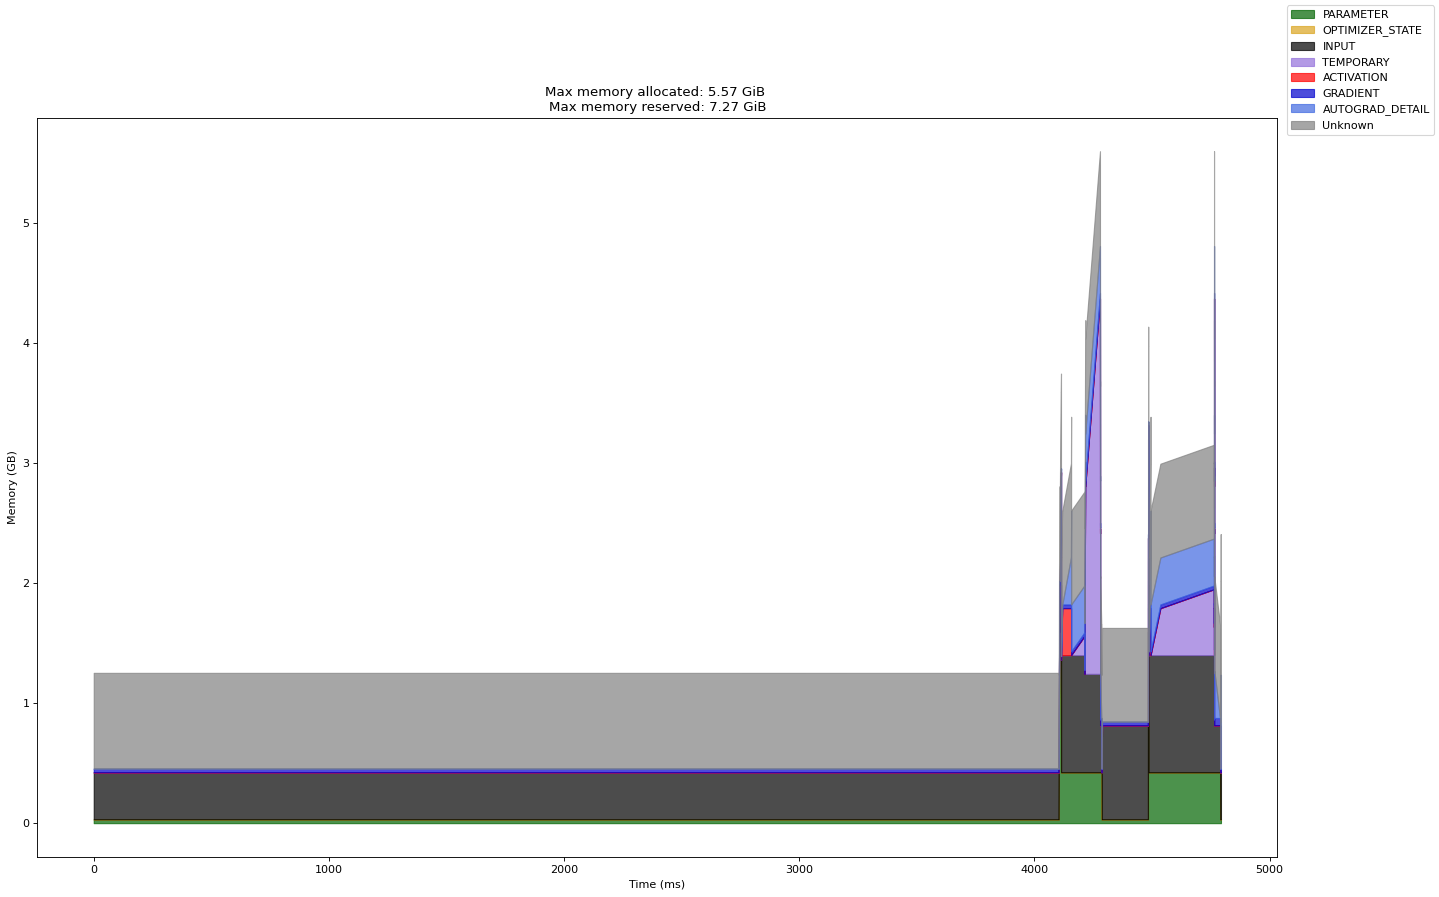

In [8]:
# --- Main Execution ---
if __name__ == "__main__":
    # Model parameters
    batch_size = int(102400)
    input_dim = 1024
    hidden_dim = 4096
    output_dim = 1024
    keep_ratio = 0.1
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # --- Profile the standard model ---
    # print("Profiling standard nn.Linear model...")
    # standard_model = SimpleTestModel(input_dim, hidden_dim, output_dim, backdrop_method="No_drop", device=device)
    # standard_model = torch.compile(standard_model, fullgraph=True, mode="reduce-overhead")
    # inputs = torch.randn(batch_size, input_dim)
    # profile_model(standard_model, inputs, "standard_model", device)

    # --- Profile the backdrop model ---
    for methods in ["fixed", "original", "sbp-style"]:
        print(f"Profiling {methods} model...")
        backdrop_model = SimpleTestModel(input_dim, hidden_dim, output_dim, backdrop_method=methods, keep_ratio=keep_ratio, device=device)
        backdrop_model = torch.compile(backdrop_model, fullgraph=True, mode="reduce-overhead")
        inputs = torch.randn(batch_size, input_dim)
        profile_model(backdrop_model, inputs, f"{methods}_model", device)

In [6]:
print(torch.__version__)
print(torch.cuda.is_available())

2.8.0+cu128
True
